In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
import ast

import re

pd.options.display.max_columns = 300
pd.options.display.max_colwidth = 200
pd.options.display.min_rows = 200
pd.options.display.max_rows = 200


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        filePath = os.path.join(dirname, filename)
        fileCsv = pd.read_csv(filePath)
        
        display(filePath)
        display(fileCsv.head())
        display(fileCsv.shape)

        variable = Path(filename).stem
        exec(f'data_{variable} = fileCsv')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

'/kaggle/input/nbme-score-clinical-patient-notes/sample_submission.csv'

,id,location
0,00016_000,0 100
1,00016_001,NaN
2,00016_002,200 250;300 400
3,00016_003,NaN
4,00016_004,75 110


(5, 2)

'/kaggle/input/nbme-score-clinical-patient-notes/patient_notes.csv'

,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student health clinic complaining of heart pounding. Mr. Cleveland's mother has given verbal consent for a history, physical examination, and treatment\r\n-began ..."
1,1,0,"17 yo male with recurrent palpitations for the past 3 mo lasting about 3 - 4 min, it happened about 5 - 6 times since the beginning. One time durign a baskeball game two days ago light headedness,..."
2,2,0,Dillon Cleveland is a 17 y.o. male patient with no significant PMH who presents with complaints of heart pounding. This has been going on for a few months and happens once or twice a month. He can...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \r\nNOTHING IMPROVES OR EXACERBATES THE SYMPTOMS ACCORDING TO HIM; IT CAN HAPPEN ANY TIME; MAY TAKE A FEW MINUTES; LAST TIME HAPPENED 2 DAYS AGO DURING...
4,4,0,"17yo male with no pmh here for evaluation of palpitations. States for the last 3-4mo he has felt that his heart with intermittently ""beat out of his chest,"" with some associated difficulty catchin..."


(42146, 3)

'/kaggle/input/nbme-score-clinical-patient-notes/features.csv'

,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myocardial-infarction
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded


(143, 3)

'/kaggle/input/nbme-score-clinical-patient-notes/train.csv'

,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']


(14300, 6)

'/kaggle/input/nbme-score-clinical-patient-notes/test.csv'

,id,case_num,pn_num,feature_num
0,00016_000,0,16,0
1,00016_001,0,16,1
2,00016_002,0,16,2
3,00016_003,0,16,3
4,00016_004,0,16,4


(5, 4)

In [3]:
data_features.to_csv('deleteMe.csv')

# Objectives  

`id = {00016_001}`
Given the patient (pn_num=16)(look for the corresponding patient history notes), with specified feature needed (feat_num=001). Identify the target `position`, which is the (start, stop) index of the string that is related to the interested feature.  

# EDA

In [4]:
a = data_features.groupby('case_num').feature_text.apply(lambda series: series.value_counts()).reset_index()
display(a.head())
a.shape
# the number of features is still 143 rows. 
# this suggest one feature cannot appear in more than 1 case
# thus case_num can be used to select the candiate for the features

,case_num,level_1,feature_text
0,0,Family-history-of-MI-OR-Family-history-of-myocardial-infarction,1
1,0,Family-history-of-thyroid-disorder,1
2,0,Chest-pressure,1
3,0,Intermittent-symptoms,1
4,0,Lightheaded,1


(143, 3)

In [5]:
# the count of features in each case_num
# looks almost evenly distributed
data_features.groupby('case_num').feature_text.apply(len)

case_num
0    13
1    13
2    17
3    16
4    10
5    18
6    12
7     9
8    18
9    17
Name: feature_text, dtype: int64

## `patient_notes.csv` and `train.csv`
There are 42,146 notes, and 14,300 rows of labelled data

In [6]:
'unique patients in notes', len(data_patient_notes.pn_num.unique())

('unique patients in notes', 42146)

In [7]:
'patients in train data', len(data_train.pn_num.unique()) # 1000 patients in the training notes

('patients in train data', 1000)

In [8]:
# can a patient be in different case?
'number of patients having more than one case', sum(data_train.groupby('pn_num').case_num.apply(lambda series: len(series.unique())) > 1)

('number of patients having more than one case', 0)

In [9]:
patientInTrain = data_train.pn_num
data_patient_notes.pn_num.isin(patientInTrain).sum() # all thousand notes found
# with 14k notes, only 1000 notes comes with information annotation

1000

In [10]:
display(data_patient_notes.head())
display(data_patient_notes.shape)


data_train = pd.merge(data_train, data_features,
                      on='feature_num', how='left',
                      suffixes=('', '_duplicate')
                     )
data_train = data_train.loc[:,~data_train.columns.str.endswith('_duplicate')]
display(data_train.head())
display(data_train.shape)

,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student health clinic complaining of heart pounding. Mr. Cleveland's mother has given verbal consent for a history, physical examination, and treatment\r\n-began ..."
1,1,0,"17 yo male with recurrent palpitations for the past 3 mo lasting about 3 - 4 min, it happened about 5 - 6 times since the beginning. One time durign a baskeball game two days ago light headedness,..."
2,2,0,Dillon Cleveland is a 17 y.o. male patient with no significant PMH who presents with complaints of heart pounding. This has been going on for a few months and happens once or twice a month. He can...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \r\nNOTHING IMPROVES OR EXACERBATES THE SYMPTOMS ACCORDING TO HIM; IT CAN HAPPEN ANY TIME; MAY TAKE A FEW MINUTES; LAST TIME HAPPENED 2 DAYS AGO DURING...
4,4,0,"17yo male with no pmh here for evaluation of palpitations. States for the last 3-4mo he has felt that his heart with intermittently ""beat out of his chest,"" with some associated difficulty catchin..."


(42146, 3)

,id,case_num,pn_num,feature_num,annotation,location,feature_text
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],Family-history-of-MI-OR-Family-history-of-myocardial-infarction
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693'],Family-history-of-thyroid-disorder
2,00016_002,0,16,2,['chest pressure'],['203 217'],Chest-pressure
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']",Intermittent-symptoms
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258'],Lightheaded


(14300, 7)

In [11]:
data_train = pd.merge(data_train, data_patient_notes,
                     on=['pn_num', 'case_num'])

In [12]:
print(data_train.shape, 'total number of data entry')
print(len(data_train.pn_history.unique()), 'unique number of patient notes')

(14300, 8) total number of data entry
1000 unique number of patient notes


EDA Questions:
* for each note(patient), how many labels are present in the text
* for each note(patient), what is the len of the text(char and token count)
* for every annotation, what is the distribution of char/token count of the text (some feature might need more words to describe)

In [13]:
data_train['annotationParsed'] = data_train.annotation.apply(lambda anno: ast.literal_eval(anno))

In [14]:
data_train[data_train.location.str.contains(';')].head()

,id,case_num,pn_num,feature_num,annotation,location,feature_text,pn_history,annotationParsed
48,00082_009,0,82,9,"['heart pounding', 'heart racing', 'heart pounding']","['85 99', '126 138', '126 131;143 151']",heart-pounding-OR-heart-racing,17 yo M w/ no cardiac or arrhythmia PMH presents complaining of 3 months of episodic heart pounding. Pt reports sensation of heart racing and pounding out of chest about 5-6 times total over the ...,"[heart pounding, heart racing, heart pounding]"
91,00211_000,0,211,0,['Father MI'],['682 688;695 697'],Family-history-of-MI-OR-Family-history-of-myocardial-infarction,"HPI: Patient is a 17 yo m with a c/o of palpitations. Palpitations began a few months ago. States that palpitations are sudden, unpredictable and feel like his heart is pounding fast/jumping out ...",[Father MI]
96,00211_005,0,211,5,['Denies sweating'],['462 468;473 481'],No-hair-changes-OR-no-nail-changes-OR-no-temperature-intolerance,"HPI: Patient is a 17 yo m with a c/o of palpitations. Palpitations began a few months ago. States that palpitations are sudden, unpredictable and feel like his heart is pounding fast/jumping out ...",[Denies sweating]
100,00211_009,0,211,9,"['palpitations', 'Palpitations', 'palpitations', 'heart is pounding', 'heart is fast']","['40 52', '55 67', '104 116', '161 178', '161 169;179 183']",heart-pounding-OR-heart-racing,"HPI: Patient is a 17 yo m with a c/o of palpitations. Palpitations began a few months ago. States that palpitations are sudden, unpredictable and feel like his heart is pounding fast/jumping out ...","[palpitations, Palpitations, palpitations, heart is pounding, heart is fast]"
125,00225_008,0,225,8,"['drinks coffee', 'drinks energy drinks']","['461 467;483 489', '461 467;506 519']",Caffeine-use,"17 y/o previously healthy male here with heart pounding. States a few months ago, he started having episodes of feeling like his heart is pound/jumping out of his chest. Denies any anxiety, sweati...","[drinks coffee, drinks energy drinks]"


## location explained

for each `pn_history` note, 

In [15]:
data_train['locationParsed'] = data_train.location.str.replace(';', "','")
data_train['locationParsed'] = data_train.locationParsed.apply(lambda anno: ast.literal_eval(anno))
data_train['locationParsed'] = data_train['locationParsed'].apply(
lambda listedStrings: list(tuple(item.split(' ')) for item in listedStrings)
)
data_train['locationParsed'] = data_train['locationParsed'].apply(
lambda listed_StringTuple: list((int(a[0]), int(a[1])) for a in listed_StringTuple) if listed_StringTuple else []
)

In [16]:
annoByPatient = data_train.groupby(['pn_num']).annotationParsed

<AxesSubplot:ylabel='Frequency'>

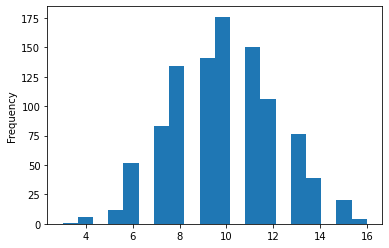

In [17]:
# number of labels per note/patient
annoByPatient.apply(
lambda series: sum(series.apply(len)>=1)
).plot.hist(bins=20)